In [91]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools

In [92]:
pretrained_model = "lenet_mnist_model.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True

In [93]:
# LeNet Model 定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #畳み込み層nn.Conv2d(入力のチャネル数, 出力のチャネル数，カーネルの1辺のサイズ)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() #過学習を防ぐためにいくつかのノードを無効にする
        self.fc1 = nn.Linear(320, 50) #全結合層nn.Linear(入力のサイズ(20channel×4height×4width), 出力サイズ) height, weightについては計算して事前に出す
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) #活性化関数Relu, Maxプーリング
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) #サイズを調整x.view(-1, 指定するサイズ)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNISTのTest datasetと dataloaderの定義
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=False)

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)

# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [4]:
# FGSM による攻撃用のコード
def fgsm_attack(image,  data_grad):
    # データの勾配の各要素のsign値を取得します
    sign_data_grad = data_grad.sign()
    # 入力画像の各ピクセルを調整して、ノイズが追加された画像を作成します
    perturbed_image = image + 0.1*sign_data_grad
    # [0,1]の範囲になるようデータをクリップします
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # ノイズが追加された画像を返します
    return perturbed_image

In [17]:
def fgsm_attack(image, data_grad):
    data_grad_sum = 0
    for i in data_grad[0][0]:
        for j in i:
            data_grad_sum += j
    
    data_grad_avg = data_grad_sum / (28 * 28)
    perturbed_image = image + (data_grad > data_grad_avg * 10).float() - (data_grad < -data_grad_avg * 10).float()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [87]:
def fgsm_attack(image, data_grad):
    data_grad_chain = list(itertools.chain.from_iterable(data_grad[0][0]))
    threshold_p = heapq.nlargest(25, data_grad_chain)[24]
    threshold_n = heapq.nsmallest(25, data_grad_chain)[24] 
    # threshold_p = torch.Tensor([heapq.nlargest(15, data_grad_chain)[14]]).to("cuda")
    # threshold_n = torch.Tensor([heapq.nsmallest(15, data_grad_chain)[14]]).to("cuda")
    # for i in range(28):
    #     for j in range(28):
    #         if data_grad[0][0][i][j] >= threshold_p:
    #             image[0][0][i][j] = torch.Tensor([1]).to("cuda")
    #         if data_grad[0][0][i][j] <= threshold_n:
    #             image[0][0][i][j] = torch.Tensor([-1]).to("cuda")
    # perturbed_image = image + (data_grad[0][0] >= threshold_p).float() - (data_grad[0][0] <= threshold_n).float()
    perturbed_image = image + (data_grad >= threshold_p).float() - (data_grad <= threshold_n).float()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [110]:
def fgsm_attack(image, data_grad):
    data_grad_chain = list(itertools.chain.from_iterable(data_grad[0][0]))
    threshold = heapq.nlargest(20, list(map(abs, data_grad_chain)))[19]
    perturbed_image = image + (data_grad >= threshold).float() - (data_grad <= -threshold).float()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [16]:
def fgsm_attack(image, data_grad):
    data_grad_max = max(data_grad)
    data_grad_min = min(data_grad)
    perturbed_image = image + (data_grad == data_grad_max).float() - (data_grad == data_grad_min).float()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [111]:
def test( model, device, test_loader):

    # 精度カウンター
    correct = 0
    adv_examples = []

    # テスト用データセット内の全てのサンプルをループします
    for data, target in test_loader:

        # データとラベルをデバイス（CPUもしくはGPU）に送信します
        data, target = data.to(device), target.to(device)

        # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。
        data.requires_grad = True

        # データをモデルに順伝播させます
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

        # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
        if init_pred.item() != target.item():
            continue

        # 損失を計算します
        loss = F.nll_loss(output, target)

        # 既存の勾配を全てゼロにします
        model.zero_grad()

        # 逆伝播させてモデルの勾配を計算します
        loss.backward()

        # データの勾配を取得します
        data_grad = data.grad.data
        
        # FGSMによる攻撃の関数を呼び出します
        perturbed_data = fgsm_attack(data, data_grad)

        # ノイズ付き画像を再度分類します
        output = model(perturbed_data)

        # 攻撃の成功を確認します
        final_pred = output.max(1, keepdim=True)[1] # log-probabilityが最大のインデックスを取得します

        if final_pred.item() == target.item():
            correct += 1
        else:
            # あとで可視化するために敵対的サンプルのうちいくつかを保存
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )


    # epsilonごとの最終的な精度を算出
    final_acc = correct/float(len(test_loader))
    print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))

    # 精度と敵対的サンプルを返却
    return final_acc, adv_examples

In [112]:
accuracies = []
examples = []

# 各epsilonごとにテストを実行
acc, ex = test(model, device, test_loader)
accuracies.append(acc)
examples.append(ex)

Test Accuracy = 4412 / 10000 = 0.4412


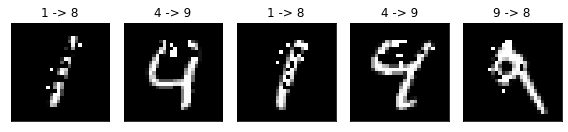

In [113]:
cnt = 0
plt.figure(figsize=(8,10))

for j in range(len(examples[0])):
    cnt += 1
    plt.subplot(1,len(examples[0]),cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig,adv,ex = examples[0][j]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()